In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

import os

2024-11-20 20:14:37.893365: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 20:14:38.393666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 20:14:38.397473: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 20:14:39.802090: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Extracting Features from Frames and Data Exploration ##

<b>⚠️ Don't run</b> 
(ideally)

This is the part where I extract landmarks and other features from the video frames to collect a dataset in the form of a table. It is not a very fast process (maybe around 10min) The resulting table is already saved and ready to be worked with. 

In [2]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [3]:
bg_alphabet = ['A','B', 'V', 'G', 'D', 'E', 'J', 'Z', 'I', 'Ik', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'F', 'H', 'C', 'CH','SH', 'SHt', 'Y', 'Yrm', 'YU', 'YA']

In [5]:
video_folders = sorted(os.listdir('./videos'))

In [6]:
# video_folders = ['vid1', 'vid2', 'vid3', 'vid3.2', 'vid3.3', 'vid4', 'vid5', 'vid6']

['vid1', 'vid2', 'vid3', 'vid3.2', 'vid3.3', 'vid4', 'vid5', 'vid6']

In [5]:
FRAMES_BACK = 3

In [6]:
xs_cols = [f'x{i}' for i in range(21)]
ys_cols = [f'y{i}' for i in range(21)]
landarks_cols = xs_cols + ys_cols

In [100]:
colors_by_video = {
    'vid2' : 'green',
    'vid1': 'blue', 
    'vid3': 'orange',
    'vid3.2': 'orange',
    'vid3.3': 'orange',
    'vid4': 'purple',
    'vid5': 'red',
    'vid6': 'plum'
}

Writing down mp landmarks indexes for plot purposes

<!-- 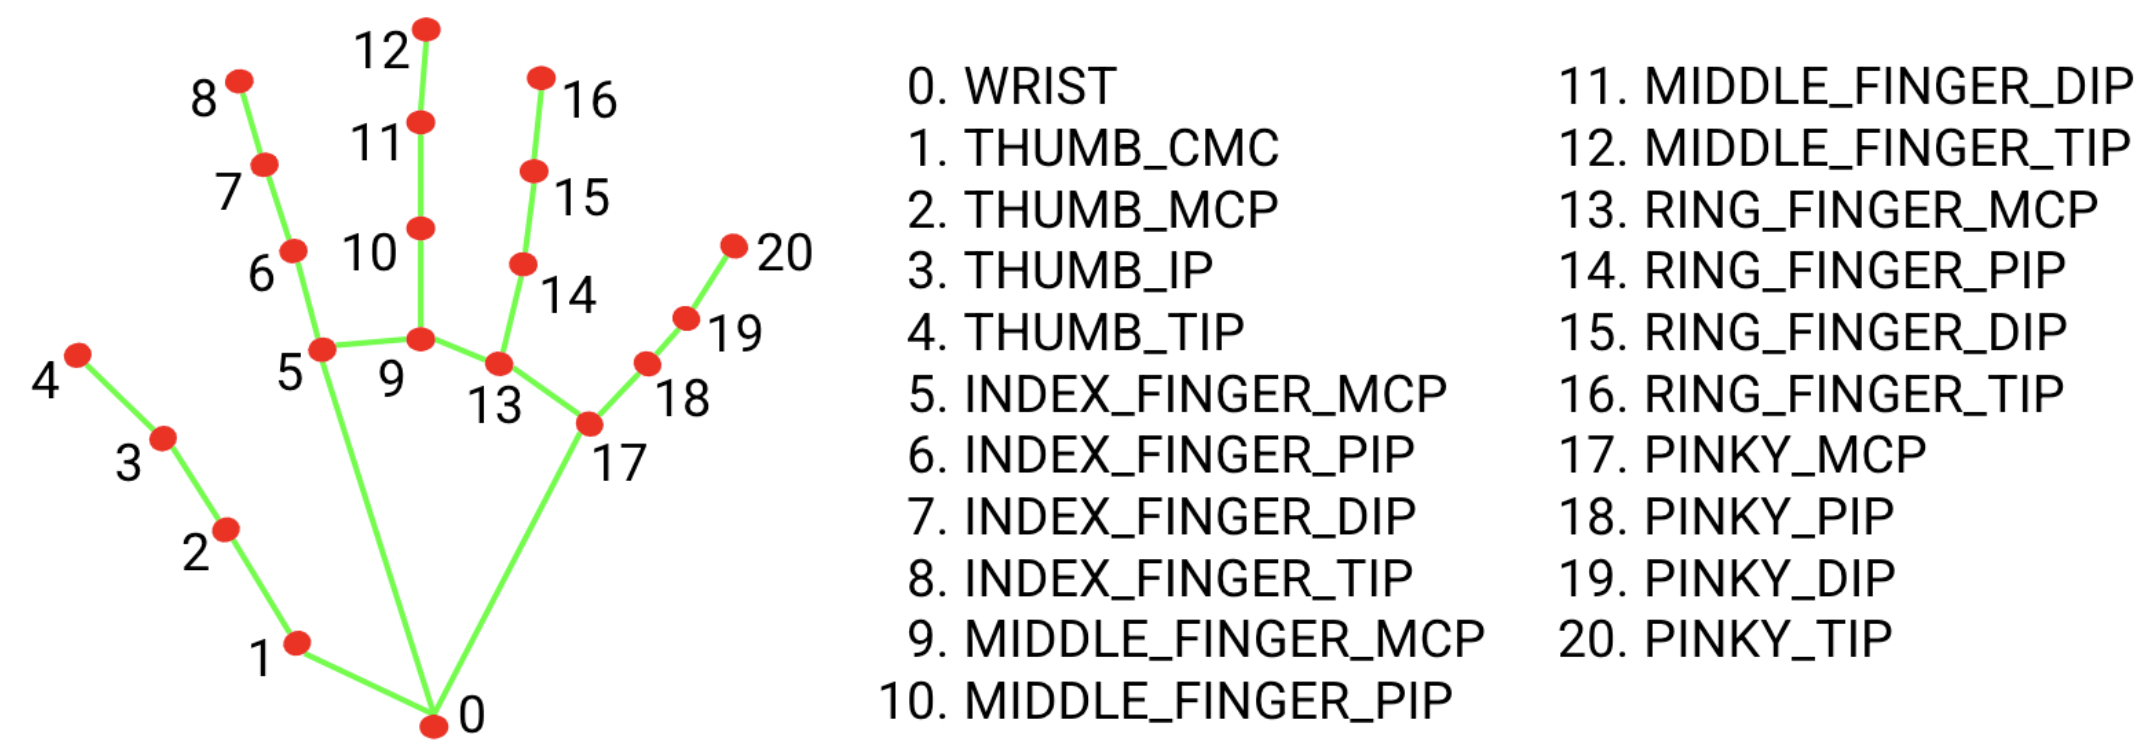\ -->
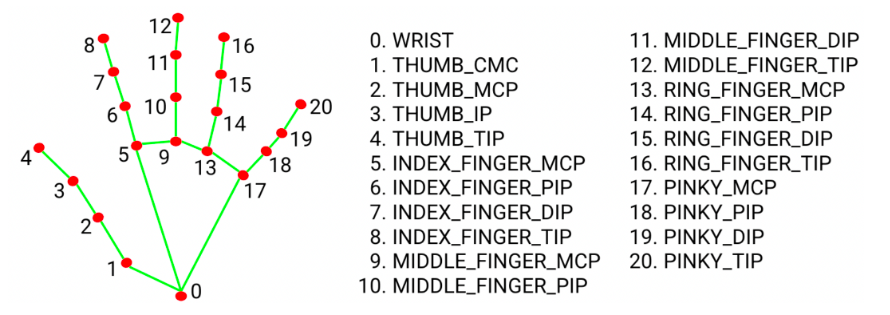

In [94]:
thumb = [0, 1, 2, 3, 4]
pointer = [0, 5, 6, 7, 8]
middle = [9, 10, 11, 12]
ring = [13, 14, 15 ,16]
pinky = [0, 17, 18, 19, 20]
top_palm = [5, 9, 13, 17]
hand_lines = [thumb, pointer, middle, ring, pinky, top_palm]

In [7]:
def get_bar_chart_of_letter_movement(letter):
    letter_df = hands_data.loc[(landmarks_df.letter == letter)]
    labels = []
    means = []
    for video, group in letter_df.groupby('video'):
        means.append(1 - group.iou0.mean())
        labels.append(video)
        
        plt.bar(labels, means, color = 'plum')
    
    # plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.ylabel('Avegare (1 - IoU) between frames')
    plt.xlabel('Video sample')
    plt.title(f'Average movement in "{letter}" videos')
    
    plt.show()


In [97]:
def plot_letter_data(letter, num = len(video_folders)):
    count = 1
    for video, group in hands_data.loc[hands_data.letter == letter].groupby('video'):
        if count > num:
            break
        hand_sample = group.iloc[0]
        hand_sample_xs = hand_sample[xs_cols]
        hand_sample_ys = hand_sample[ys_cols]
        
        # # (1 - y) because mediapipe y = 0 is at top, and here it's at bottom 
        plt.scatter(hand_sample_xs, [1 - hand_sample_ys], label = video, color = colors_by_video[video])

        # plotting the line connections
        for line_idxs in hand_lines:
            plt.plot([hand_sample_xs[ind] for ind in line_idxs], [1 - hand_sample_ys[ind] for ind in line_idxs], color = colors_by_video[video], alpha = 0.3)
        count += 1
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Letter {letter} landmarks by video')
    plt.show()

In [98]:
def get_scattet_plot_of_letter(letter):
    letter_df = landmarks_df.loc[(landmarks_df.letter == letter)]
    fig, ax = plt.subplots()
    
    for video, group in letter_df.groupby('video'):
        ax.scatter(group.x1, group.y1, label = video, color = colors_by_video[video])
    
    plt.legend(title = 'Video')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Bounding box width')
    plt.ylabel('Bounding box height')
    plt.title(f'Palm position in hand bounding box in "{letter}" videos')
    
    plt.show()

In [10]:
def plot_letter_landmark_data(letter, show = True):
    video_lms =  hands_data.loc[hands_data.letter == letter].groupby('video').first().reset_index()
    for i in range(len(xs_cols)):
        sns.scatterplot(x = video_lms[xs_cols[i]], y = [1 - j for j in video_lms[ys_cols[i]]])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Letter {letter} landmarks by index')
    plt.show()

In [11]:
colors = {17: 'Fuchsia', 18: 'MediumOrchid', 19: 'DarkTurquoise', 20: 'DodgerBlue'}

def get_color_for_lm(lm_no):
    # pinky landmarks:
    if lm_no >= 17 and lm_no <= 20:
        return colors[lm_no]
    return 'Gainsboro'

def compare_landmark_placement(l1, l2):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
    video_lms =  hands_data.loc[hands_data.letter == l1].groupby('video').first().reset_index()
    for i in range(len(xs_cols)):
        axes[0].scatter(x = video_lms[xs_cols[i]], y = [1 - j for j in video_lms[ys_cols[i]]], color = get_color_for_lm(i))
        axes[0].set_title(f'landmark position for letter {l1}')
    video_lms =  hands_data.loc[hands_data.letter == l2].groupby('video').first().reset_index()
    for i in range(len(xs_cols)):
        axes[1].scatter(x = video_lms[xs_cols[i]], y = [1 - j for j in video_lms[ys_cols[i]]], color = get_color_for_lm(i))
        axes[1].set_title(f'landmark position for letter {l2}')
        

In [141]:
def get_bounding_box_ratios(letter):
    ratios = []
    video_lms =  hands_data.loc[hands_data.letter == letter].groupby('video').first().reset_index()
    for i in range(video_lms.shape[0]):
        row = video_lms.loc[i]
        x1, y1, x2, y2 = row.bbox_x1, row.bbox_y1, row.bbox_x2, row.bbox_y2
        ratio = (x2 - x1) / (y2 - y1)
        ratios.append(ratio)
    return ratios, np.mean(ratios)

## Data preprocessing ##

In [185]:
img_name = 'vid114.jpg'
img_path = f'./data/{bg_alphabet[0]}/{video_folders[0]}/{img_name}'
img = cv2.imread(img_path)

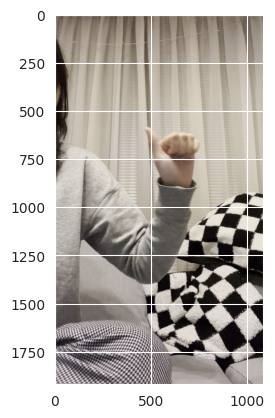

In [186]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

## Load hand landmark finder: ##

Loading Mediapipe's Hand Landmarker, which finds 21 landmarks on the human hand. This will be used to extract landmarks for each letter sign.

In [193]:
base_options = python.BaseOptions(model_asset_path = 'hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options = base_options,
                                       num_hands = 2)
detector = vision.HandLandmarker.create_from_options(options)

I0000 00:00:1731697812.230153   10016 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731697812.240381  568792 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD Radeon(TM) Vega 10 Graphics (RAVEN, DRM 3.44.0, 5.16.0-051600-generic, LLVM 12.0.0)


In [188]:
def get_hand_detection_data(hand_img_path):
    mp_hand_img = mp.Image.create_from_file(hand_img_path)
    detection_result = detector.detect(mp_hand_img)
    return detection_result

In [189]:
hand = get_hand_detection_data(img_path)

In [190]:
dir(hand)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'hand_landmarks',
 'hand_world_landmarks',
 'handedness']

### Extract landmarks and form csv ###

#### Three main parts: ####
<uol>
    <li> <b>Remove image size information - </b>
    Mediapipe's landmarks return the normalized coordinates. That means that the width and height of the image have been scaled from 0 to 1 and the landmarks have been scaled accordingly. This is good if the position within the image is important. In my case it is not so I scale the landmarks within their own bounding box.
    </li>
    <li> <b>Flip all hands to 'Left' -</b>   
    If the hand is recognized as 'Left', I flip the landmarks so all hands are 'Right' - making it easier for the algorithm with my limited data
    </li>
    <li> <b> Add (very primitive) movement 'history' - </b>
    And last, I add the IoU for 3 steps back (steps = FREQ, in this case, the samples were taken from the videos with 5 frames apart). This is in hopes that the algorithm will be able to pick up on the few letters with movement.
    </li>
</uol>



(Bounding box ratio is also added later on. Bonding box coordinates, handedness, video and other useless columns are going to be dropped later.)

In [21]:
def get_hand_bounding_box(lm_xs, lm_ys):
    """
        takes all xs and ys of the points within dersied bounding box
        returns
        (x1, y1) - upper left corner
        (x2, y2) - lower right corner
    """
    x1, y1 = min(lm_xs), min(lm_ys)
    x2, y2 = max(lm_xs), max(lm_ys)
    return [x1, y1, x2, y2]

In [22]:
def get_box_area(x1, y1, x2, y2):
    return (x2 - x1) * (y2 - y1)

def get_iou(prev_bbox, bbox):
    """
        returns:
            (intersection area) / (union area) of 2 bounding boxes
    """
    prev_x1, prev_y1, prev_x2, prev_y2 = prev_bbox
    x1, y1, x2, y2 = bbox

    # bounding box of intersection
    x1_inter = max(x1, prev_x1)
    y1_inter = max(y1, prev_y1)
    x2_inter = min(x2, prev_x2)
    y2_inter = min(y2, prev_y2)

    if x2_inter < x1_inter or y2_inter < y1_inter:
        return 0

    inter_area = get_box_area(x1_inter, y1_inter, x2_inter, y2_inter)
    bbox_area = get_box_area(x1, y1, x2, y2)
    prev_bbox_area = get_box_area(prev_x1, prev_y1, prev_x2, prev_y2)

    union_area = bbox_area + prev_bbox_area - inter_area

    iou = inter_area / union_area
    return iou

In [23]:
def scale(coords):
    return [(coord - min(coords)) / (max(coords) - min(coords)) for coord in coords]

In [192]:
def get_hand_landmarks_sample(hand):
    handedness = hand.handedness[0][0].display_name
    hand_landmarks = hand.hand_landmarks[0];

    x_lms = [landmark.x for landmark in hand.hand_landmarks[0]]
    y_lms = [landmark.y for landmark in hand.hand_landmarks[0]]
    
    return handedness, x_lms, y_lms

In [25]:
def get_hand_movement(x_lms, y_lms, movement_df, this_video_image_count):
    """
        x_lms, y_lms: arrays with the xs and ys of the hand landmarks 
        movement_df: array with all movement data
        this_video_image_count: which frame of the original video is this
        returns:
            hand_movement: array consisting of x1, y1, x2, y2, iou1, iou2 ..
            (which are the bounding box and the history of ious)
    """
    # Save current bounding box
    curr_hand_bbox = get_hand_bounding_box(x_lms, y_lms,)
    hand_movement = curr_hand_bbox

    # First frame gets None for all ious since there are no prev frames
    if this_video_image_count == 1:
        hand_movement += [None for i in range (FRAMES_BACK)]
        
    # Save ious of 3 frames back (or FRAMES_BACK amount)
    else:
        prev_hand_bbox = movement_df[-1][:4]
        prev_hand_ious = movement_df[-1][4:-1]
        
        # calc IoU for curr and prev frame
        iou1 = get_iou(prev_hand_bbox, curr_hand_bbox)
        hand_movement.append(iou1)

        if len(prev_hand_ious) < FRAMES_BACK - 1:
            conole.log(f'Error: not enough iou elements in movement array for frame before {img_path}')
            return None
        hand_movement += prev_hand_ious

    return hand_movement

In [146]:
landmarks_df = []
movement_df = []

for folder in bg_alphabet:
    for subfolder in os.listdir(f'./data/{folder}'):
        print (f'In folder {folder}/{subfolder}')
        curr_folder = f'./data/{folder}/{subfolder}'
        this_video_image_count = 0
        
        for image_name in os.listdir(curr_folder):
            img_path = f'{curr_folder}/{image_name}'
            hand = get_hand_detection_data(img_path)
            
            # Mediapipe will fail to find landmarks in some of the images:
            if len(hand.hand_landmarks) == 0:
                print (f'Error: No hand landmarks were found for file: {img_path}')
                continue

            this_video_image_count += 1
            handedness, x_lms, y_lms = get_hand_landmarks_sample(hand)
            
            hand_movement = get_hand_movement(x_lms, y_lms, movement_df, this_video_image_count)
            if hand_movement == None:
                continue

            if handedness == 'Left':
                x_lms = [1 - x for x in x_lms]

            hand_landmarks_sample = [subfolder] + [folder] + [handedness] + scale(x_lms) + scale(y_lms)
            landmarks_df.append(hand_landmarks_sample)
            movement_df.append(hand_movement)
                

In folder A/vid5
In folder A/vid3
In folder A/vid2
In folder A/vid1
Error: No hand landmarks were found for file: ./data/A/vid1/vid119.jpg
Error: No hand landmarks were found for file: ./data/A/vid1/vid116.jpg
Error: No hand landmarks were found for file: ./data/A/vid1/vid120.jpg
In folder A/vid4
In folder A/vid6
In folder B/vid5
In folder B/vid3
In folder B/vid2
In folder B/vid1
In folder B/vid4
In folder B/vid6
In folder V/vid5
In folder V/vid3
In folder V/vid2
In folder V/vid1
In folder V/vid4
In folder V/vid6
In folder G/vid5
In folder G/vid3
In folder G/vid2
In folder G/vid1
In folder G/vid4
In folder G/vid6
In folder D/vid5
In folder D/vid3
In folder D/vid2
Error: No hand landmarks were found for file: ./data/D/vid2/vid224.jpg
Error: No hand landmarks were found for file: ./data/D/vid2/vid223.jpg
In folder D/vid1
In folder D/vid4
In folder D/vid6
In folder E/vid5
In folder E/vid2
In folder E/vid1
In folder E/vid4
In folder E/vid6
In folder J/vid5
In folder J/vid3
In folder J/vid2

In [147]:
np.array(movement_df).shape

(4944, 7)

In [148]:
np.array(landmarks_df).shape

(4944, 45)

In [149]:
movement_arr = movement_df
landmarks_arr = landmarks_df

### Converting to DataFrames ###

In [150]:
landmarks_df = pd.DataFrame(landmarks_arr, columns=['video', 'letter', 'handedness'] + [f'x{i}' for i in range(21)] + [f'y{i}' for i in range(21)])

In [151]:
landmarks_df

,video,letter,handedness,x0,x1,x2,x3,x4,x5,x6,...,y11,y12,y13,y14,y15,y16,y17,y18,y19,y20
0,vid5,A,Right,0.000000,0.298585,0.589927,0.819361,1.000000,0.466651,0.540799,...,0.435490,0.684241,0.161815,0.010515,0.409296,0.649844,0.151952,0.082736,0.358426,0.552739
1,vid5,A,Right,0.000000,0.306282,0.596950,0.820887,1.000000,0.463757,0.533525,...,0.421714,0.661699,0.187642,0.005444,0.396684,0.628823,0.184765,0.064232,0.330719,0.518521
2,vid5,A,Right,0.000000,0.294553,0.584742,0.815453,1.000000,0.457893,0.545746,...,0.400664,0.640337,0.206533,0.000000,0.369371,0.601761,0.203401,0.050252,0.298704,0.491879
3,vid5,A,Right,0.000000,0.299749,0.589658,0.818989,1.000000,0.456175,0.534047,...,0.436597,0.685997,0.187496,0.016461,0.418851,0.662700,0.174111,0.084371,0.361900,0.557870
4,vid5,A,Right,0.000000,0.302422,0.589079,0.819702,1.000000,0.472918,0.556787,...,0.414278,0.655293,0.197715,0.005243,0.389987,0.617290,0.191575,0.065040,0.327109,0.513130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,vid6,YA,Left,0.450969,0.823368,1.000000,0.839550,0.515719,0.862324,0.764867,...,0.108221,0.000000,0.504372,0.346161,0.479374,0.582300,0.596154,0.544071,0.629683,0.694661
4940,vid6,YA,Left,0.452181,0.798633,1.000000,0.893958,0.565637,0.867088,0.740066,...,0.110719,0.000000,0.510536,0.353243,0.462872,0.554836,0.601570,0.539448,0.603661,0.660110
4941,vid6,YA,Left,0.465303,0.839469,1.000000,0.824326,0.507723,0.884854,0.788349,...,0.106603,0.000000,0.502840,0.343680,0.478745,0.580817,0.597542,0.542819,0.628745,0.694067
4942,vid6,YA,Left,0.468407,0.821340,1.000000,0.849579,0.538096,0.860405,0.776243,...,0.104721,0.000000,0.504318,0.338975,0.473620,0.580787,0.594625,0.532559,0.616876,0.684853


In [152]:
movement_df = pd.DataFrame(movement_arr, columns=['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2'] + [f'iou{i}' for i in range(FRAMES_BACK)])

In [153]:
movement_df

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,iou0,iou1,iou2
0,0.322455,0.370920,0.797951,0.541817,NaN,NaN,NaN
1,0.341282,0.357097,0.795587,0.528368,0.817100,NaN,NaN
2,0.332500,0.369330,0.788439,0.547808,0.807487,0.817100,NaN
3,0.323212,0.376243,0.795982,0.551371,0.910129,0.807487,0.817100
4,0.325921,0.362573,0.790583,0.536340,0.834478,0.910129,0.807487
...,...,...,...,...,...,...,...
4939,0.423981,0.189437,0.713327,0.655404,0.939626,0.921071,0.912029
4940,0.436789,0.211860,0.693096,0.673106,0.815738,0.939626,0.921071
4941,0.442631,0.200439,0.722885,0.657512,0.828676,0.815738,0.939626
4942,0.423404,0.194073,0.715812,0.659849,0.895533,0.828676,0.815738


In [154]:
hands_data = pd.concat([landmarks_df, movement_df], axis=1)
hands_data

,video,letter,handedness,x0,x1,x2,x3,x4,x5,x6,...,y18,y19,y20,bbox_x1,bbox_y1,bbox_x2,bbox_y2,iou0,iou1,iou2
0,vid5,A,Right,0.000000,0.298585,0.589927,0.819361,1.000000,0.466651,0.540799,...,0.082736,0.358426,0.552739,0.322455,0.370920,0.797951,0.541817,NaN,NaN,NaN
1,vid5,A,Right,0.000000,0.306282,0.596950,0.820887,1.000000,0.463757,0.533525,...,0.064232,0.330719,0.518521,0.341282,0.357097,0.795587,0.528368,0.817100,NaN,NaN
2,vid5,A,Right,0.000000,0.294553,0.584742,0.815453,1.000000,0.457893,0.545746,...,0.050252,0.298704,0.491879,0.332500,0.369330,0.788439,0.547808,0.807487,0.817100,NaN
3,vid5,A,Right,0.000000,0.299749,0.589658,0.818989,1.000000,0.456175,0.534047,...,0.084371,0.361900,0.557870,0.323212,0.376243,0.795982,0.551371,0.910129,0.807487,0.817100
4,vid5,A,Right,0.000000,0.302422,0.589079,0.819702,1.000000,0.472918,0.556787,...,0.065040,0.327109,0.513130,0.325921,0.362573,0.790583,0.536340,0.834478,0.910129,0.807487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4939,vid6,YA,Left,0.450969,0.823368,1.000000,0.839550,0.515719,0.862324,0.764867,...,0.544071,0.629683,0.694661,0.423981,0.189437,0.713327,0.655404,0.939626,0.921071,0.912029
4940,vid6,YA,Left,0.452181,0.798633,1.000000,0.893958,0.565637,0.867088,0.740066,...,0.539448,0.603661,0.660110,0.436789,0.211860,0.693096,0.673106,0.815738,0.939626,0.921071
4941,vid6,YA,Left,0.465303,0.839469,1.000000,0.824326,0.507723,0.884854,0.788349,...,0.542819,0.628745,0.694067,0.442631,0.200439,0.722885,0.657512,0.828676,0.815738,0.939626
4942,vid6,YA,Left,0.468407,0.821340,1.000000,0.849579,0.538096,0.860405,0.776243,...,0.532559,0.616876,0.684853,0.423404,0.194073,0.715812,0.659849,0.895533,0.828676,0.815738


### Exploration (<-- THIS PART IS COPIED TO THE MAIN IPYNB)

The data has been already seen in the form of photos / videos, so in this part I mostly try to confirm my expectations:
<ol>
    <li>The iou for letters that include horizontal/vertical movement should be lower (e.g. SH and SHt)</li>
    <li>The iou for letters that include rotiational movement should be higher (rotation is not caught by iou, e.g. K and D)</li>
    <li>y0 - the palm root landmark should usually be 0 or 1 (if the hand is flipped)</li>
</ol>

The landmarks and IoUs are all between 0 and 1, as expected. The bounding boxes still have negative values due to detecting landmarks outside of the frame.

In [155]:
hands_data.describe().T

,count,mean,std,min,25%,50%,75%,max
x0,4944.0,0.395681,0.236998,0.000000,0.225552,0.379008,0.543916,1.000000
x1,4944.0,0.655761,0.225441,0.000000,0.489472,0.674079,0.841834,1.000000
x2,4944.0,0.789293,0.210218,0.000000,0.663360,0.834595,0.971381,1.000000
x3,4944.0,0.786067,0.187314,0.000000,0.726971,0.830789,0.906434,1.000000
x4,4944.0,0.725584,0.261116,0.000000,0.509632,0.780373,1.000000,1.000000
x5,4944.0,0.621260,0.230645,0.000000,0.470528,0.643222,0.803481,1.000000
x6,4944.0,0.665521,0.218156,0.000000,0.506913,0.659272,0.867778,1.000000
x7,4944.0,0.695783,0.226005,0.026419,0.513871,0.750269,0.900530,1.000000
x8,4944.0,0.709681,0.264372,0.000000,0.503763,0.762126,0.968322,1.000000
x9,4944.0,0.432640,0.157113,0.000000,0.318920,0.446977,0.554427,1.000000


In [156]:
hands_data.dtypes

video          object
letter         object
handedness     object
x0            float64
x1            float64
x2            float64
x3            float64
x4            float64
x5            float64
x6            float64
x7            float64
x8            float64
x9            float64
x10           float64
x11           float64
x12           float64
x13           float64
x14           float64
x15           float64
x16           float64
x17           float64
x18           float64
x19           float64
x20           float64
y0            float64
y1            float64
y2            float64
y3            float64
y4            float64
y5            float64
y6            float64
y7            float64
y8            float64
y9            float64
y10           float64
y11           float64
y12           float64
y13           float64
y14           float64
y15           float64
y16           float64
y17           float64
y18           float64
y19           float64
y20           float64
bbox_x1   

### How many samples of each letter? ###

Checking how (un)balanced the data it when it comes to the target classes (letter) <br/>
The spikes are usually when the letter involve movement and the videos have been longer (more frames extracted)

In [157]:
landmarks_df.letter.value_counts().values.mean()

164.8

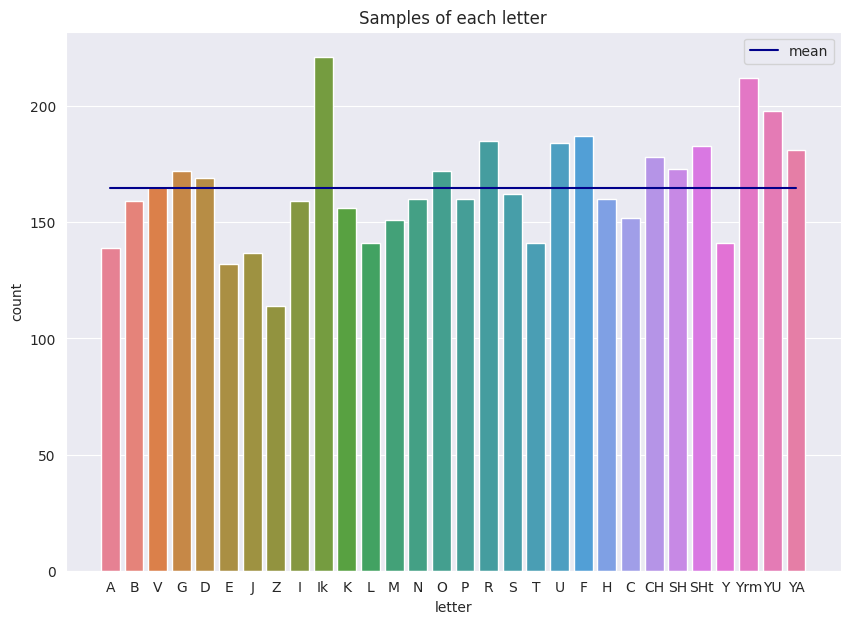

In [158]:
plt.figure(figsize = (10,7))
sns.set_style("darkgrid")
sns.countplot(landmarks_df, x = 'letter', hue = 'letter', palette = sns.color_palette("husl", 30),  legend = False)
plt.plot([i for i in range (30)], [landmarks_df.letter.value_counts().values.mean() for i in range(30)], color = 'darkblue', label = 'mean')
plt.title('Samples of each letter')
plt.legend()
plt.show()

The root of the palm usually marks the lowest point of the bounding box or the highest (when the letter sign has the hand pointed downwards)

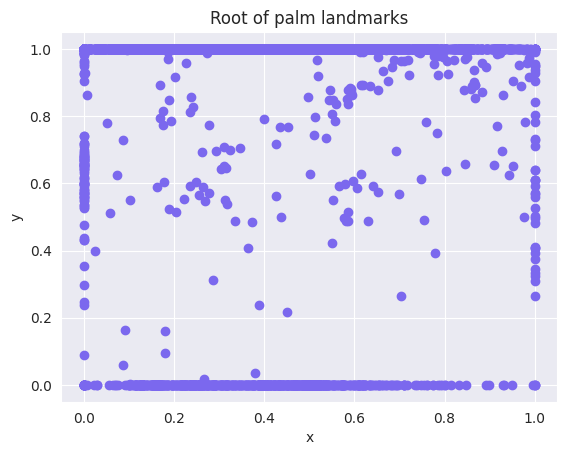

In [159]:
plt.scatter(landmarks_df.x0, landmarks_df.y0, color = "MediumSlateBlue")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Root of palm landmarks')
plt.show()

### Finding patterns with landmarks ###

Starting off simple by visualizing the landmarks of one sample of the letter 'V'. 'V' is when the hand is facing the viewer with fingers extended, much like a wave (👋).  Even without taking a look at mediapipe's landmarks documentation, we can roughly make out a hand already.

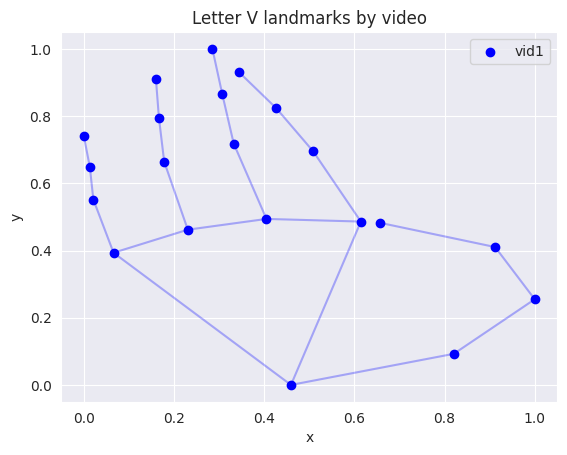

In [160]:
plot_letter_data('V', 1)

### A hand from every video: ###

We are looking at a plot which shows the landmarks from every video's first frame sample. Due to having scaled the landmarks, it is not as easy to see the actual hand, but we can observe that clusters are forming. Showing that there is some kind of similarity between the landmarks of the same letter in the different videos/people doing them. <br/>

(Although, if we squint, we can see a fist with an extended thumb)

Showing only the first 4 videos because all of them make the plot harder to read.

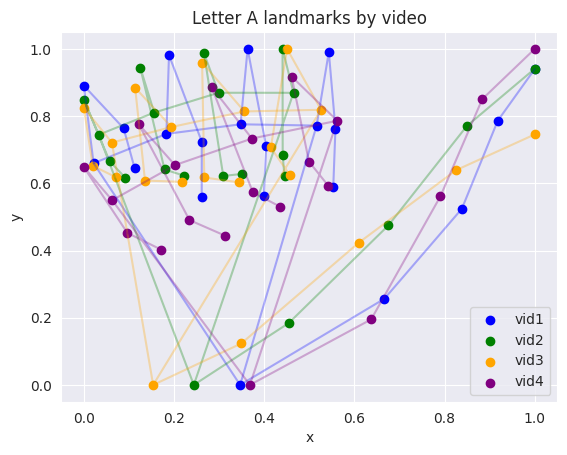

In [161]:
plot_letter_data('A', 4)

#### Plots that look similar: ###

E looks a lot like V, however, keep in mind that this is not the whole picture. On this plot we see the dots grouped by video, not by their number. That means that although the 'clusters' look the same, the difference in the bounding box and specific landmark postion may differ.

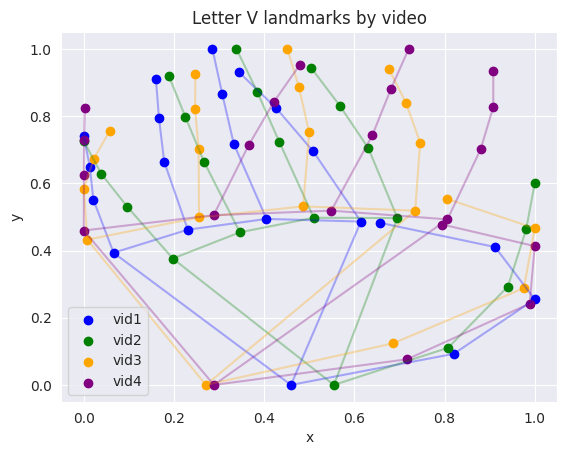

In [162]:
plot_letter_data('V', 4) # "wave" - 👋

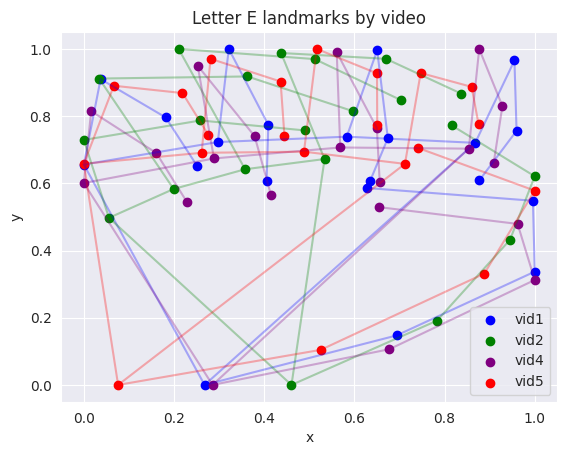

In [103]:
plot_letter_data('E', 4) # fist - ✊

#### Plot E and V by landmark position ####

To compare, this time <b> each color represents a landmark index </b> (not a video). This is to see that parts of the fingers are placed differently between the two letters. <br/>
For example, on the rightmost in E, we see purple/pink (bottom part of the pinky) and next to them are light/dark blue (top part of the pinky). They appear next to each other because in E, <b>the pinky is flexed inwards</b>, towards the palm. On the 'V' plot we can see that those same colors are on top of each other - <b>the pinky is extended upwards</b>.
<br/>

(The same could be observed for the other fingers if we were to color them too.)

The weakness of this plot is that, because of scaling, it doesn't portray the ratio of the bounding boxes. The bounding box of V, where the hand is extended (much like saying 'hello' 👋) the bounding box's height > width. Wtih 'E' where the hand is like a fist (✊), the width is roughly the same as the height. Scroll next to see ratio comparison.

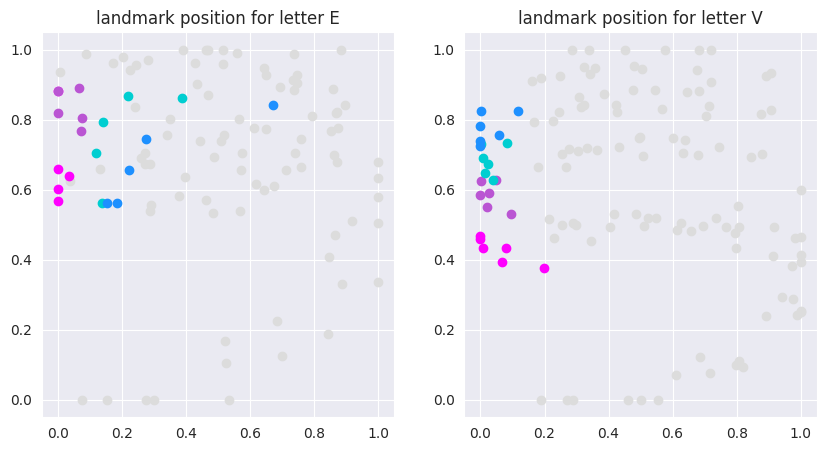

In [163]:
compare_landmark_placement('E', 'V')

#### Bouding box ratios: ####

As mentioned above, ratios can not be interpreted from the plot above so I've made a simple comparison. As expected, the ratio width:height of 'E' is closer to 1 than 'V'. <br/>
What is interesting is the one higher value of 'V': after inspection it turns out that variations of 'V' exist and the person from whose video the sample was taken, was extending their thumb outwards (instead of inwards like the others) causing the width to grow. And we can see from the 'V' plot up that vid4 differs a little bit - the thumb landmarks are further away from the rest. 

In [164]:
E_ratios, E_mean = get_bounding_box_ratios('E')
V_ratios, V_mean = get_bounding_box_ratios('V')

print ('E ratios: ', E_ratios)
print ('E mean: ', E_mean)
print ('\nV ratios: ', V_ratios)
print ('V mean: ', V_mean)

E ratios:  [1.13361623113368, 0.9637068415471359, 1.0044332494232495, 1.1444000368675602, 2.020336294177708]
E mean:  1.2532985306298667

V ratios:  [0.7349684035188698, 1.0355956829855342, 0.5905079258492039, 0.7086408029085901, 0.7671037694452701, 0.9312133480942357]
V mean:  0.7946716554669507


### Same form, movement and rotation in one ###

'I' and 'Ik' have same form (landmarks) but 'Ik' has movement and rotation. Movement is tracked with IoU (Ik's IoU is lower). Rotation can be seen in the plot below (for the pinky). Since no history of landmark changes is kept, however, rotation alone will not be able to be 'detected'/predicted.

In [46]:
movement_means = hands_data.groupby('letter')[['iou1', 'iou2', 'iou0']].mean()
movement_means = movement_means.sort_values(by = 'iou1').T[[ 'I', 'Ik' ]]
movement_means.columns = ['I (stat)', 'Ik (mov)']
movement_means

,I (stat),Ik (mov)
iou1,0.600860,0.181242
iou2,0.596075,0.172541
iou0,0.608916,0.187488


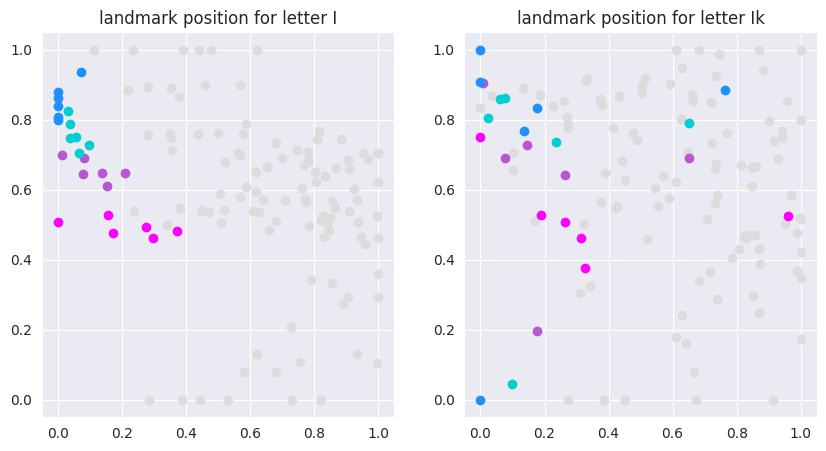

In [47]:
compare_landmark_placement('I', 'Ik')

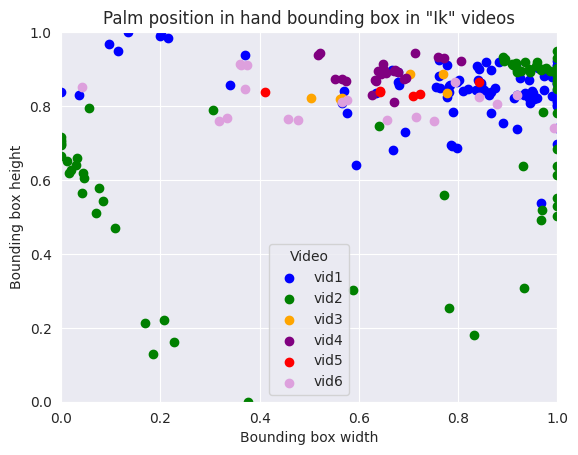

In [165]:
get_scattet_plot_of_letter('Ik')

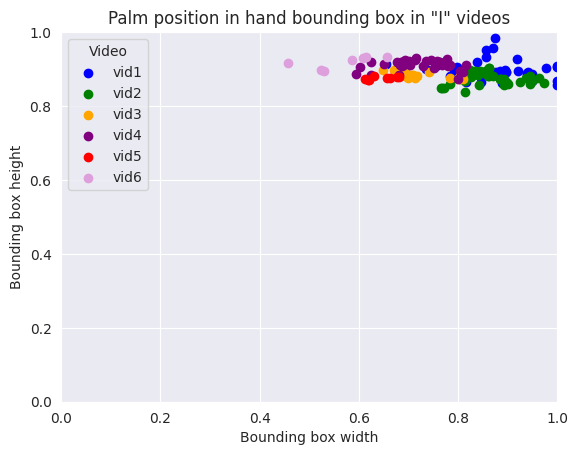

In [166]:
get_scattet_plot_of_letter('I')

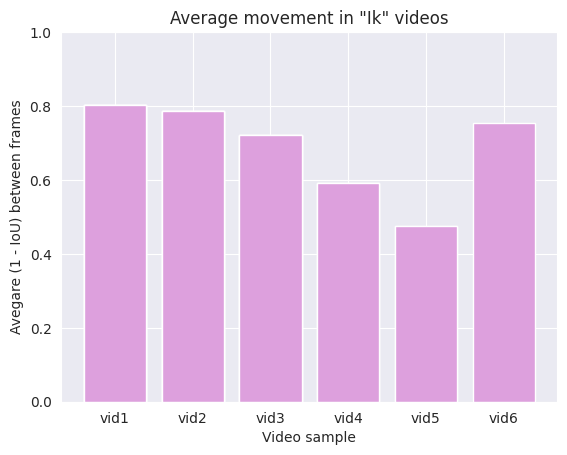

In [167]:
get_bar_chart_of_letter_movement('Ik')

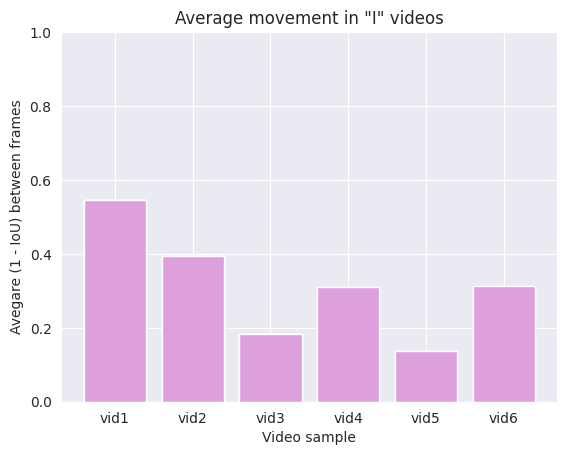

In [168]:
get_bar_chart_of_letter_movement('I')

### Same form, movement in one ###
'SH' and 'SHt', 'Y' and 'Yrm' are two pairs with the same form (landmarks) but one is static ('SH' and 'Y') and the other has movement ('Sht' and 'Yrm'). Plotting the landmarks expecting them to be the same. For these letter I will rely on the IoU fields. (Explored in detail further down)

In this snippet we can confirm that letter with movement have significantly lower IoU on average:

In [169]:
movement_means = hands_data.groupby('letter')[['iou1', 'iou2', 'iou0']].mean()
movement_means = movement_means.sort_values(by = 'iou1').T[[ 'SH', 'SHt', 'Y', 'Yrm' ]]
movement_means.columns = ['SH (stat)', 'SHt (mov)', 'Y (stat)', 'Yrm (mov)']
movement_means

,SH (stat),SHt (mov),Y (stat),Yrm (mov)
iou1,0.741195,0.222931,0.753506,0.307160
iou2,0.742529,0.222053,0.753119,0.300203
iou0,0.739469,0.231791,0.753038,0.313949


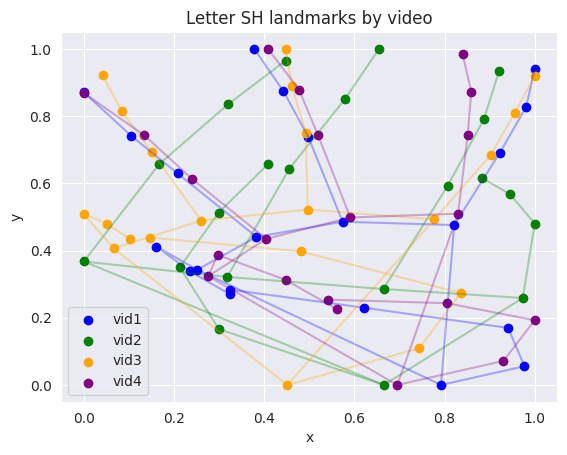

In [170]:
plot_letter_data('SH', 4)

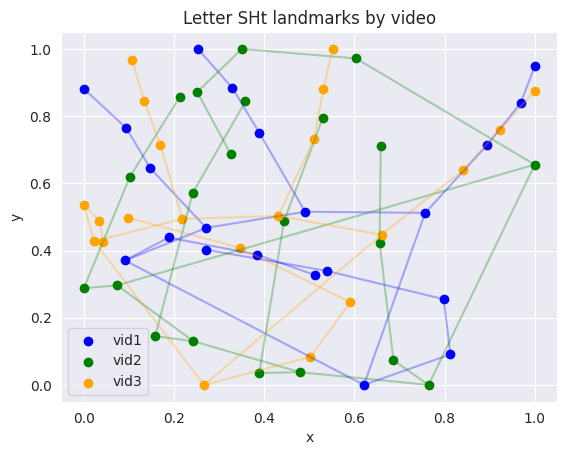

In [174]:
plot_letter_data('SHt', 3)

### Same form, movement in both ###

This is where I expect my data to flop - 'D' and 'K', which have the same form (landmarks) and are differentiated by the movement. ('K' rotates on the palm landmark, 'D' makes a circle with the index and middle finger in the air) There is no <i>big</i> horizontal/vertical movement of the bounding box - <b> IoU will give equal values </b>. I expect the landmarks to be roughly the same. The only difference will be a small change in the bounding box ratios but since I am not keeping "history" of bounding box ratio, this will not be something the algorithm will be able to use.

In [175]:
movement_means = hands_data.groupby('letter')[['iou1', 'iou2', 'iou0']].mean()
movement_means = movement_means.sort_values(by = 'iou1').T[[ 'D', 'K' ]]
movement_means.columns = ['D', 'K']
movement_means

,D,K
iou1,0.450257,0.422095
iou2,0.445164,0.410064
iou0,0.456503,0.433272


Not really any information telling us that there's a circular movement in the first and a 'wave' in the second.

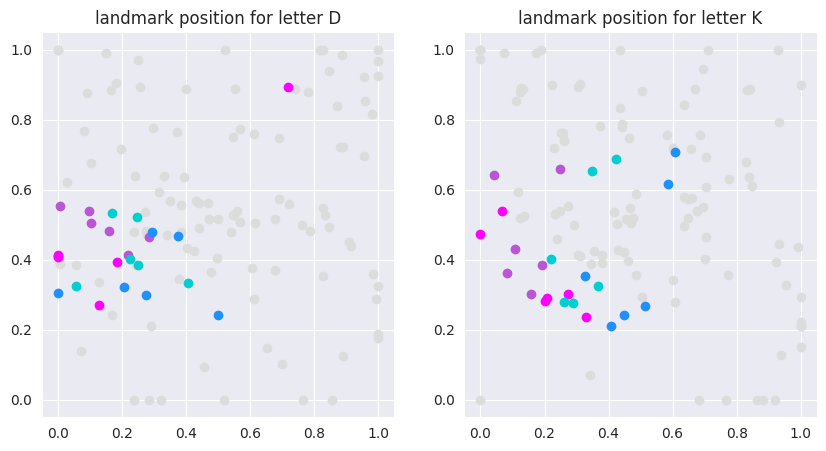

In [176]:
compare_landmark_placement('D', 'K')

### IoU features ###

In [177]:
median_values = hands_data.groupby('letter')[['iou1', 'iou2', 'iou0']].median()
median_values = median_values.sort_values(by = 'iou1')

In [178]:
movement_letters = ['D', 'Z', 'Ik', 'K', 'SHt', 'Yrm']

The IoU succcessfully caught the movement in the gestures. This will be very helpful in distinguishing between the pairs with same form but one is moving. It won't be very helpful in distinguishing between those that have same from <u>and</u> movement.

There even is a 0.8 difference between the movement letters MAX and the static MIN. I expect that to be leveraged as a separator between these two subsets.

In [179]:
# MOVEMENT 
median_values.T[movement_letters].T.describe()

,iou1,iou2,iou0
count,6.000000,6.000000,6.000000
mean,0.291097,0.285188,0.299342
std,0.142648,0.139606,0.144655
min,0.098769,0.102017,0.106660
25%,0.203355,0.200703,0.205906
50%,0.278428,0.264672,0.288909
75%,0.403799,0.393264,0.414769
max,0.467037,0.464256,0.476612


In [180]:
# STATIC
median_values.T[[letter for letter in bg_alphabet if letter not in movement_letters]].T.describe()

,iou1,iou2,iou0
count,24.000000,24.000000,24.000000
mean,0.676546,0.673442,0.677816
std,0.066579,0.066831,0.065843
min,0.566209,0.563520,0.566209
25%,0.622021,0.619009,0.620938
50%,0.665493,0.665493,0.671757
75%,0.725260,0.722494,0.726136
max,0.801084,0.802120,0.800399


#### Use bounding box ratio ###

Maybe the differentiation between K and D can be saved by taking the bounding box ratios. (With K the hand rotates and the width becomes larger, whether with D the tilt needed for the circular motion is more subtle). 

In [181]:
K_ratios, K_mean = get_bounding_box_ratios('K')
D_ratios, D_mean = get_bounding_box_ratios('D')

print ('E ratios: ', K_ratios)
print ('E mean: ', K_mean)
print ('\nV ratios: ', D_ratios)
print ('V mean: ', D_mean)

E ratios:  [1.1786693953070217, 0.8959095994212756, 1.2108972683564847, 0.9582424953184774, 1.067522348746512, 0.5076062570971057]
E mean:  0.9698078940411462

V ratios:  [1.0199139063283749, 1.5632199529352795, 0.598844103060496, 0.7743759205576876, 0.6203327183915621, 0.8842512533201015]
V mean:  0.9101563090989169


In [182]:
landmarks_df.to_csv('landmarks.csv')

In [183]:
movement_df.to_csv('movements.csv')

In [184]:
hands_data.to_csv('hands_data.csv')